### 함수 저장소

1. 학습 데이터셋 비교 가시화

visualize_multiple_dataloaders([test_loader], test_loader, images_per_loader=5)

2. 실험 진행용 학습모델 저장

### 1. 라이브러리 불러오기

In [1]:
import os
import shutil
import random
from torch.utils.data import DataLoader
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
from torchvision import transforms


# Visualization
import cv2
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 2. 데이터셋 정의 - 비오염

In [3]:
# Data loading and transformations
transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomCrop(32, padding=4),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# Use PyTorch's torchvision.transforms.ToTenesor() to convert the dataset to tensor format
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)
add_set = CIFAR100(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Use PyTorch's DataLoader to divide the dataset into mini-batches and load the data
train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False)
add_loader = DataLoader(dataset=add_set, batch_size=64, shuffle=False)

In [6]:
def visualize_multiple_dataloaders(dataloaders, trainloader, images_per_loader=5):
    num_loaders = len(dataloaders)
    classes = trainloader.dataset.classes

    # 플롯 크기 설정
    plt.figure(figsize=(8,8))

    for i, loader in enumerate(dataloaders):
        # 각 DataLoader에서 배치 하나 가져오기
        batch = next(iter(loader))
        images, labels = batch
        images = torch.clamp(images, 0, 1)  # 이미지를 0과 1 사이로 클리핑하여 표시 문제 방지

        # 각 DataLoader에서 선택한 이미지 수만큼 시각화
        for j in range(images_per_loader):
            idx = i * images_per_loader + j
            plt.subplot(num_loaders, images_per_loader, idx + 1)
            plt.imshow(images[j].permute(1, 2, 0))  # 이미지 차원 변경: (C, H, W) -> (H, W, C)
            plt.title(classes[labels[j].item()])
            plt.axis('off')

    plt.tight_layout()
    plt.show()

### 3. 신경망 코딩

#### 3.1. ResNet50

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

#### 3.2. Autoencoder 모델 정의

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder 부분
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),   # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 8x8 -> 4x4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128)  # latent space (압축된 표현)
        )
        
        # Decoder 부분
        self.decoder = nn.Sequential(
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),     # 16x16 -> 32x32
            nn.Tanh()  # 0~1 범위로 출력
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### 3.3. U-Net 모델 정의

In [9]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # 인코더 (Contracting Path)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        )
        
        self.encoder_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        )
        
        self.encoder_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        )

        # 병목층 (Bottleneck)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # 디코더 (Expanding Path)
        self.decoder_1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')  # 4x4 -> 8x8
        )
        
        self.decoder_2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')  # 8x8 -> 16x16
        )
        
        self.decoder_3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')  # 16x16 -> 32x32
        )
        
        # 최종 출력 레이어
        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, padding=1)  # 출력 채널 3 (RGB 이미지)

    def forward(self, x):
        # 인코더
        enc1 = self.encoder(x)
        enc2 = self.encoder_2(enc1)
        enc3 = self.encoder_3(enc2)
        
        # 병목층
        bottleneck = self.bottleneck(enc3)
        
        # 디코더
        dec1 = self.decoder_1(bottleneck)
        dec2 = self.decoder_2(dec1)
        dec3 = self.decoder_3(dec2)
        
        # 최종 출력
        out = self.final_conv(dec3)
        return out


### 4. 신경망 학습과 테스트 진행

#### 4.1 Resnet

In [10]:
# Evaluate function
def evaluate(model, device, test_loader):
  model.eval()
  total_correct = 0
  with torch.no_grad():
     for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      _, preds = torch.max(output, 1)
      total_correct += (preds == target).sum().item()

  accuracy = 100 * total_correct / len(test_loader.dataset)
  return accuracy

In [11]:
# Train and evaluate function
def train_and_evaluate(model, device, train_loader, test_loader, epochs=5):
  model.train()

  criterion = nn.CrossEntropyLoss()
  # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=1e-4)

  accuracies = []

  for epoch in range(epochs):
    running_loss = 0.0
    data_iterator = iter(train_loader)
    for inputs, labels in data_iterator:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'[Epoch {epoch + 1}] loss: {running_loss / len(train_loader):.3f}')

    accuracy = evaluate(model, device, test_loader)
    accuracies.append(accuracy)
    print(f'Accuracy: {accuracy:.2f}%')

  return accuracies

#### 4.2 Autoencoder

In [12]:
# 학습 함수
def train_model(model, trainloader, epochs=5):
    model.train()

    criterion = nn.MSELoss()  # 평균 제곱 오차 (복원된 이미지와 원본 이미지 간의 차이)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        running_loss = 0.0
        for data in trainloader:
            inputs, _ = data  # 레이블은 필요 없음
            inputs = inputs.cuda()

            # 손상된 이미지 생성 (노이즈 추가)
            noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
            noisy_inputs = torch.clip(noisy_inputs, 0., 1.)  # 값이 0~1 사이로 유지되도록 조정

            optimizer.zero_grad()

            # 모델에 손상된 이미지 입력
            outputs = model(noisy_inputs)
            
            # 손실 계산
            loss = criterion(outputs, inputs)  # 원본 이미지와 복원된 이미지 간의 차이
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader)}')

#### 4.3 U-net

In [13]:
# 학습 함수
def train_model(model, trainloader, epochs=5):
    model.train()

    criterion = nn.MSELoss()  # 평균 제곱 오차 (복원된 이미지와 원본 이미지 간의 차이)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        running_loss = 0.0
        for data in trainloader:
            inputs, _ = data  # 레이블은 필요 없음
            inputs = inputs.cuda()

            # 손상된 이미지 생성 (노이즈 추가)
            noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
            noisy_inputs = torch.clip(noisy_inputs, 0., 1.)  # 값이 0~1 사이로 유지되도록 조정

            optimizer.zero_grad()

            # 모델에 손상된 이미지 입력
            outputs = model(noisy_inputs)
            
            # 손실 계산
            loss = criterion(outputs, inputs)  # 원본 이미지와 복원된 이미지 간의 차이
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader)}')

In [14]:
# Train and evaluate function
def train_and_evaluate_after(model, device, train_loader, test_loader, epochs=5):
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=1e-4)

    accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        data_iterator = iter(train_loader)
        
        # train_loader에서 반환되는 값이 3개일 경우 (inputs, model_outputs, labels)
        for inputs, model_outputs, labels in data_iterator:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # 모델 예측
            outputs = model(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'[Epoch {epoch + 1}] loss: {running_loss / len(train_loader):.3f}')

        # 테스트
        accuracy = evaluate(model, device, test_loader)
        accuracies.append(accuracy)
        print(f'Accuracy: {accuracy:.2f}%')

    return accuracies

### 5. 데이터의 오염 통합 모델

In [15]:
class AugmentedDataset(Dataset):
    """
    CIFAR-10 데이터셋에 다양한 공격을 추가하는 클래스입니다.

    Attributes:
    - dataset: 원본 데이터셋
    - perbutationset : 오염 추가용 데이터셋 (CIFAR-100)
    - attacked_ratio: 공격 비율
    - label_attack: Label 오염 활성화 여부
    - label_perterbation: Label 섭동 활성화 여부
    - alpha: 이미지 겹침 공격의 혼합 비율
    - partial_overlay: 이미지 부분 겹침 활성화 여부
    - rotational_overlay: 이미지 회전 겹침 활성화 여부
    - image_corruption: 이미지 결손 활성화 여부
    - attack_order: 공격 순서 ("label_first" 또는 "overlay_first")
    """
    def __init__(self, dataset, perterbationset, attacked_ratio=0.2, label_attack=True, label_perterbation = True, overlay=True, alpha=0.5, partial_overlay=True, rotational_overlay=True, image_corruption=True, attack_order="label_first"):
        """ AugmentedDataset 객체를 초기화합니다. """
        self.dataset = dataset
        self.perterbationset = perterbationset
        self.attacked_ratio = attacked_ratio
        self.label_attack = label_attack
        self.label_perterbation = label_perterbation
        self.overlay = overlay
        self.alpha = alpha
        self.partial_overlay = partial_overlay
        self.rotational_overlay = rotational_overlay
        self.image_corruption = image_corruption
        self.attack_order = attack_order  # 공격 순서 설정

        # 공격 인덱스 설정
        self.attacked_indices = self._select_attacked_indices(self.attacked_ratio)

        # Label 오염 생성 (라벨 공격이 활성화된 경우에만)
        self.attacked_labels = self._crazy_labels() if self.label_attack else None
        self.attacked_labels = self._label_flipper() if self.label_perterbation else None

    def _select_attacked_indices(self, ratio):
        """공격 대상 샘플의 인덱스를 선택합니다."""
        num_attack_samples = int(ratio * len(self.dataset))
        return random.sample(range(len(self.dataset)), num_attack_samples)

    def _crazy_labels(self):
        """Label 오염된 라벨 리스트를 생성합니다."""
        attacked_labels = []
        for idx in range(len(self.dataset)):
            _, original_label = self.dataset[idx]
            if idx in self.attacked_indices:
                # 원래 라벨과 다른 무작위 라벨 생성
                attacked_label = original_label
                while attacked_label == original_label:
                    attacked_label = random.randint(0, 9)
                attacked_labels.append(attacked_label)
            else:
                attacked_labels.append(original_label)
        return attacked_labels

# Label 오염을 10%의 샘플에 적용하는 함수 정의
    def _label_flipper(self):
        """
        CIFAR-10 데이터셋의 일부 샘플에 Label-Flipping오염을 가하는 함수입니다.
        airplane : 0
        automobile : 1
        bird : 2
        cat : 3
        deer : 4
        dog : 5
        frog : 6
        horse : 7
        ship : 8
        truck : 9

        Automobile - Truck
        Dog - Cat
        Deer - Horse
        Birds - Frog
        Airplane - Ship"""
        attacked_labels = []

        for idx in range(len(self.dataset)):
            # 이미지와 라벨을 가져오기
            _, label = self.dataset[idx]

            if idx in self.attacked_indices:
                # 라벨 복사 후 공격 수행
                original_label = label

                if original_label == 1:
                    label = 9
                elif original_label == 9:
                    label = 1
                elif original_label == 5:
                    label = 3
                elif original_label == 3:
                    label = 5
                elif original_label == 7:
                    label = 4
                elif original_label == 4:
                    label = 7
                elif original_label == 2:
                    label = 6
                elif original_label == 6:
                    label = 2
                elif original_label == 0:
                    label = 8
                elif original_label == 8:
                    label = 0
            # 리스트에 추가
            attacked_labels.append(label)

        return attacked_labels

    def _overlay(self, image, idx):
        """특정 이미지에 이미지 겹침 공격을 적용합니다."""
        if self.partial_overlay == False:
            if idx in self.attacked_indices and self.overlay:
                overlay_idx = random.randint(0, len(self.dataset) - 1)
                overlay_image, _ = self.dataset[overlay_idx]
                return (1 - self.alpha) * image + self.alpha * overlay_image
            return image
        
        else:
            if idx in self.attacked_indices:
                # 텐서를 PIL 이미지로 변환
                pil_image = transforms.ToPILImage()(image)

                # 두 개의 이미지를 랜덤으로 선택하여 중첩
                rand_idx_1 = random.randint(0, len(self.dataset) - 1)
                rand_idx_2 = random.randint(0, len(self.dataset) - 1)

                overlay_image_1, _ = self.dataset[rand_idx_1]
                overlay_image_2, _ = self.dataset[rand_idx_2]

                # 첫 번째 이미지를 중첩
                overlay_h_1, overlay_w_1 = overlay_image_1.shape[1], overlay_image_1.shape[2]
                scale_factor_1 = random.uniform(0.5, 1.0)
                new_h_1 = int(overlay_h_1 * scale_factor_1)
                new_w_1 = int(overlay_w_1 * scale_factor_1)

                overlay_image_1_pil = transforms.ToPILImage()(overlay_image_1)
                overlay_image_1_resized = overlay_image_1_pil.resize((new_w_1, new_h_1))

                x1 = random.randint(0, pil_image.size[0] - new_w_1)
                y1 = random.randint(0, pil_image.size[1] - new_h_1)
                pil_image.paste(overlay_image_1_resized, (x1, y1))

                # 두 번째 이미지를 중첩
                overlay_h_2, overlay_w_2 = overlay_image_2.shape[1], overlay_image_2.shape[2]
                scale_factor_2 = random.uniform(0.5, 1.0)
                new_h_2 = int(overlay_h_2 * scale_factor_2)
                new_w_2 = int(overlay_w_2 * scale_factor_2)

                overlay_image_2_pil = transforms.ToPILImage()(overlay_image_2)
                overlay_image_2_resized = overlay_image_2_pil.resize((new_w_2, new_h_2))

                x2 = random.randint(0, pil_image.size[0] - new_w_2)
                y2 = random.randint(0, pil_image.size[1] - new_h_2)
                pil_image.paste(overlay_image_2_resized, (x2, y2))

                # 여러 변형을 적용
                final_image = pil_image.copy()
                for _ in range(3):  # 세 번 변형 적용
                    max_shift = 10  # 이동 범위 (픽셀 단위)
                    shift_x = random.randint(-max_shift, max_shift)
                    shift_y = random.randint(-max_shift, max_shift)
                    transformed_image = final_image.transform(final_image.size, Image.AFFINE, (1, 0, shift_x, 0, 1, shift_y))

                    # 크기 조정 (Resizing)
                    resize_factor = random.uniform(0.5, 1.5)
                    new_size = (int(transformed_image.size[0] * resize_factor), int(transformed_image.size[1] * resize_factor))
                    transformed_image = transformed_image.resize(new_size)

                    if self.rotational_overlay == True:
                        # 회전 (Rotation)
                        rotate_angle = random.randint(-30, 30)  # -30도에서 30도 사이로 회전
                        transformed_image = transformed_image.rotate(rotate_angle)

                    # 변형된 이미지를 원본 이미지에 중첩
                    overlay_width, overlay_height = transformed_image.size
                    max_x_offset = max(0, final_image.size[0] - overlay_width)
                    max_y_offset = max(0, final_image.size[1] - overlay_height)

                    x_offset = random.randint(0, max_x_offset)
                    y_offset = random.randint(0, max_y_offset)

                    # 중첩
                    if transformed_image.mode == 'RGBA':
                        final_image.paste(transformed_image, (x_offset, y_offset), transformed_image.split()[3])  # 알파 채널 처리
                    else:
                        final_image.paste(transformed_image, (x_offset, y_offset))
                    # 최종 이미지를 텐서로 변환하여 저장

                return transforms.ToTensor()(final_image)
                    
            return image  # 이미지가 공격되지 않으면 원본 이미지 그대로 반환

    # 1. 결손 처리 함수 수정
    def _corrupt_image(self, image):
        """이미지의 일부 픽셀을 결손 처리합니다."""
        if self.image_corruption == True:
            image_np = image.numpy()  # 텐서를 NumPy 배열로 변환
            total_pixels = image_np.size
            num_corrupted_pixels = int(total_pixels * self.attacked_ratio)

            # 랜덤으로 픽셀 선택 (이미지의 플랫(flat) 배열에서 인덱스 기준)
            indices = random.sample(range(total_pixels), num_corrupted_pixels)
            flat_image = image_np.flatten()

            # 선택된 픽셀을 0으로 설정
            flat_image[indices] = 0

            # 이미지를 원래 형태로 복원
            image_np = flat_image.reshape(image_np.shape)
            return torch.tensor(image_np)
        return image

    def __len__(self):
        """데이터셋의 전체 길이를 반환합니다."""
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        데이터셋의 특정 샘플을 반환합니다.

        Args:
        - idx: 샘플 인덱스

        Returns:
        - (Tensor, int): 이미지 텐서와 라벨
        """
        # 원본 이미지와 라벨 가져오기
        image, original_label = self.dataset[idx]

        if self.attack_order == "label_first":
            # 라벨 오염 -> 이미지 겹침
            label = self.attacked_labels[idx] if self.label_attack else original_label
            image = self._overlay(image, idx)
            image = self._corrupt_image(image)
        elif self.attack_order == "overlay_first":
            # 이미지 겹침 -> 라벨 오염
            image = self._overlay(image, idx)
            label = self.attacked_labels[idx] if self.label_attack else original_label
            image = self._corrupt_image(image)
        else:
            raise ValueError(f"Invalid attack order: {self.attack_order}. Use 'label_first' or 'overlay_first'.")

        return image, label

### 실험 진행

##### 1. 오염 없는 일반적 데이터 학습 과정

In [16]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_res = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

In [17]:
acc_res = train_and_evaluate(model_res, device, train_loader, test_loader, epochs=5)

[Epoch 1] loss: 1.580
Accuracy: 52.13%
[Epoch 2] loss: 1.548
Accuracy: 56.17%
[Epoch 3] loss: 1.094
Accuracy: 62.89%
[Epoch 4] loss: 0.931
Accuracy: 68.36%
[Epoch 5] loss: 0.805
Accuracy: 73.66%


##### 2. 오염을 적용하는 데이터 학습 과정

In [18]:
train_set_attacked = AugmentedDataset(
    dataset=train_set,
    perterbationset=add_set,
    attacked_ratio=0.4,
    overlay=True,
    alpha=0.5,
    label_attack=True,
    partial_overlay=True,
    attack_order="label_first"
)

train_loader_attacked = DataLoader(dataset=train_set_attacked, batch_size=64, shuffle=True)

In [19]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_res_1 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

In [20]:
acc_res_1 = train_and_evaluate(model_res_1, device, train_loader_attacked, test_loader, epochs=5)

[Epoch 1] loss: 2.056
Accuracy: 32.94%
[Epoch 2] loss: 1.892
Accuracy: 38.60%
[Epoch 3] loss: 1.793
Accuracy: 42.38%
[Epoch 4] loss: 1.725
Accuracy: 44.63%
[Epoch 5] loss: 1.677
Accuracy: 46.14%


### 최종 비교 그래프

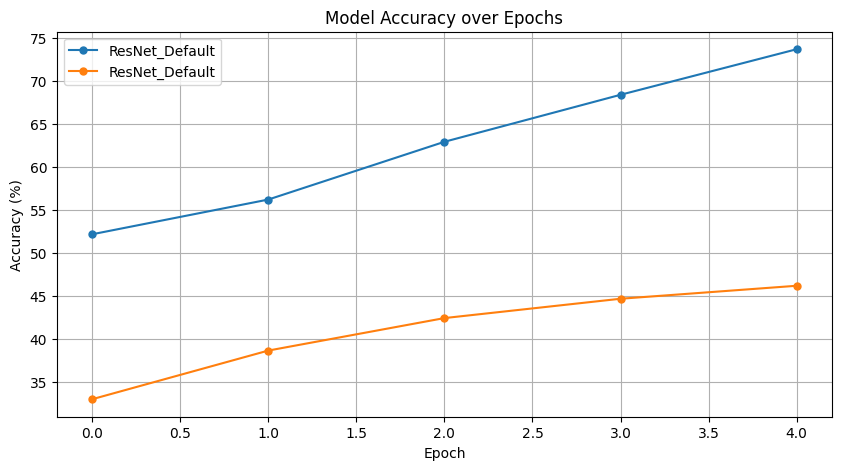

In [21]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='ResNet_Default')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

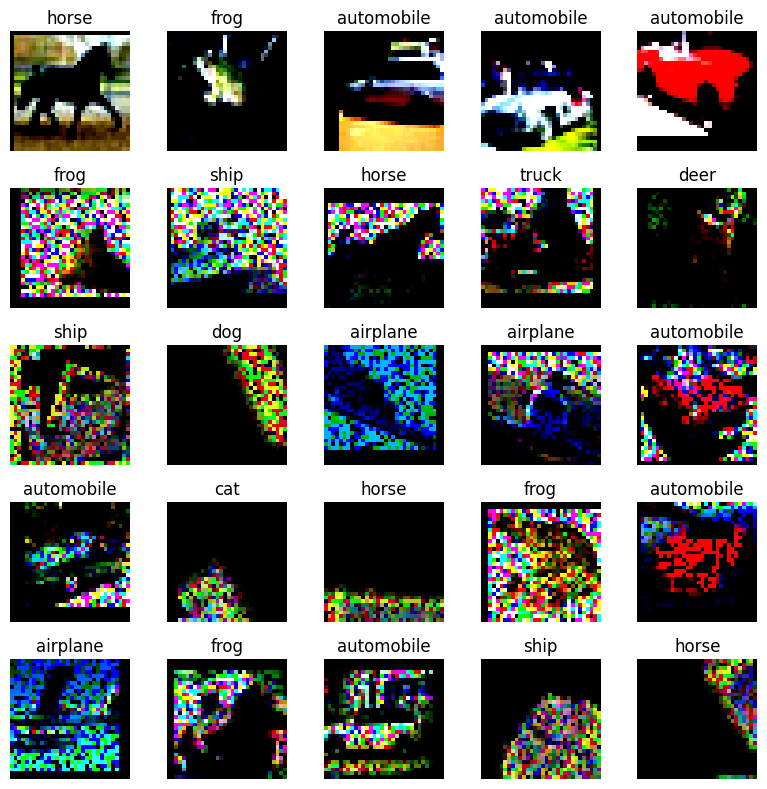

In [22]:
visualize_multiple_dataloaders([train_loader, train_loader_attacked, train_loader_attacked, train_loader_attacked, train_loader_attacked], test_loader, images_per_loader=5)

#### Poison Activation Validator

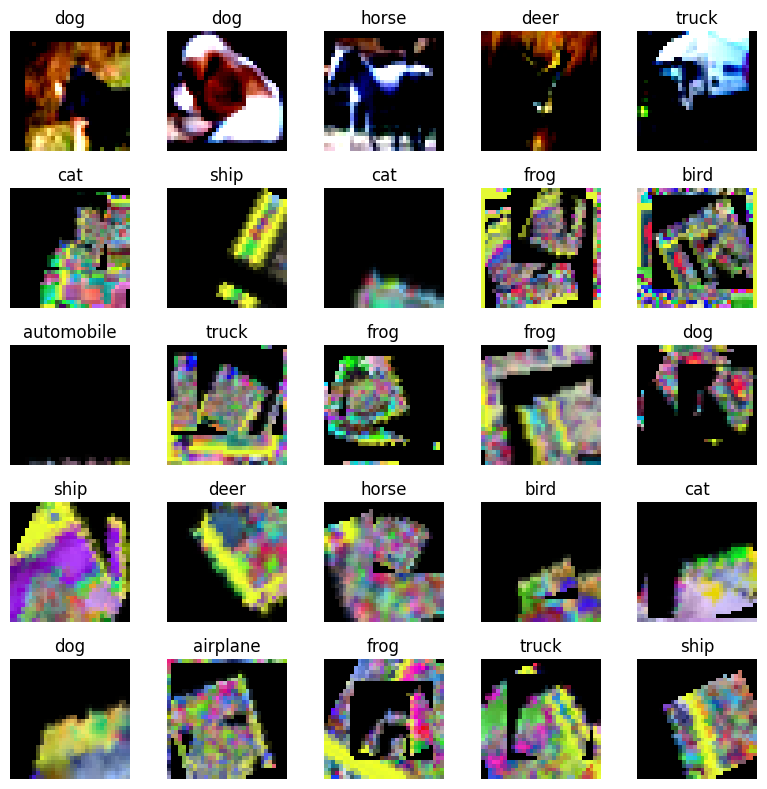

In [23]:
train_set_attacker_test = AugmentedDataset(
    dataset=train_set,
    perterbationset=add_set,
    attacked_ratio=1,
    overlay=True,
    alpha=0.9,
    label_attack=False,
    label_perterbation=False,
    partial_overlay=True,
    image_corruption=False,
    attack_order="label_first"
)

attacker_test = DataLoader(dataset=train_set_attacker_test, batch_size=64, shuffle=True)

visualize_multiple_dataloaders([train_loader, attacker_test, attacker_test, attacker_test, attacker_test], test_loader, images_per_loader=5)

### 6. Image Restoration Module

#### 중독데이터 복원 AI 학습

##### CIFAR-10을 학습데이터로 이용

In [24]:
auto_10 = Autoencoder().cuda()
unet_10 = UNet().cuda()

Autotest = train_model(auto_10, train_loader, epochs=5)
unettest = train_model(unet_10, train_loader, epochs=5)

Epoch [1/5], Loss: 0.7186790809149632
Epoch [2/5], Loss: 0.5417003298507017
Epoch [3/5], Loss: 0.5073846395668167
Epoch [4/5], Loss: 0.48963352153673195
Epoch [5/5], Loss: 0.4773612688188358
Epoch [1/5], Loss: 0.648756314345333
Epoch [2/5], Loss: 0.31897718992913165
Epoch [3/5], Loss: 0.25677317653394416
Epoch [4/5], Loss: 0.23290554754188297
Epoch [5/5], Loss: 0.21935479987003004


##### 중독데이터를 학습데이터로 이용

In [25]:
auto_attacked = Autoencoder().cuda()
unet_attacked = UNet().cuda()

Autotest_attaked = train_model(auto_attacked, train_loader_attacked, epochs=5)
unettest_attaked = train_model(unet_attacked, train_loader_attacked, epochs=5)

Epoch [1/5], Loss: 0.3941480328359872
Epoch [2/5], Loss: 0.34640331577766886
Epoch [3/5], Loss: 0.3332341195410475
Epoch [4/5], Loss: 0.32804336555092534
Epoch [5/5], Loss: 0.3240187251011429
Epoch [1/5], Loss: 0.4201047117143031
Epoch [2/5], Loss: 0.3350270585254635
Epoch [3/5], Loss: 0.31947169477677406
Epoch [4/5], Loss: 0.311663428173803
Epoch [5/5], Loss: 0.30715094716347696


##### CIFAR-100을 학습데이터로 이용

In [26]:
auto_100 = Autoencoder().cuda()
unet_100 = UNet().cuda()

Autotest_100 = train_model(auto_100, add_loader, epochs=5)
unettest_100 = train_model(unet_100, add_loader, epochs=5)

Epoch [1/5], Loss: 0.8044546859343643
Epoch [2/5], Loss: 0.595926258074658
Epoch [3/5], Loss: 0.5614724964513194
Epoch [4/5], Loss: 0.5394583864666312
Epoch [5/5], Loss: 0.5255392169022499
Epoch [1/5], Loss: 0.781627408645647
Epoch [2/5], Loss: 0.3605509108823279
Epoch [3/5], Loss: 0.28071874624018167
Epoch [4/5], Loss: 0.24941821994683933
Epoch [5/5], Loss: 0.23060773642700347


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-59.37848..120.788536].


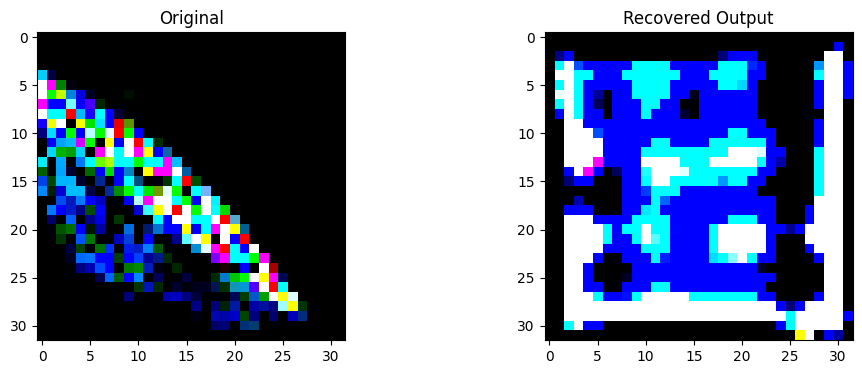

In [27]:
# 이미지 결과 확인 함수
def show_images(original, output):
    # 결과 이미지를 시각화
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    ax[0].imshow(original.permute(1, 2, 0).cpu().detach().numpy())
    ax[0].set_title('Original')
    ax[1].imshow(output.permute(1, 2, 0).cpu().detach().numpy())
    ax[1].set_title('Recovered Output')
    
    plt.show()

# 학습된 모델로 테스트 이미지 확인
unet_10.eval()
with torch.no_grad():
    data_iter = iter(train_loader_attacked)
    images, _ = next(data_iter)
    
    outputs = unet_10(images.cuda())
    
    # 첫 번째 배치의 이미지 1개만 보여주기
    show_images(images[0], outputs[0].cpu())


##### CIFAR-10을 학습데이터로 이용

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79183745].


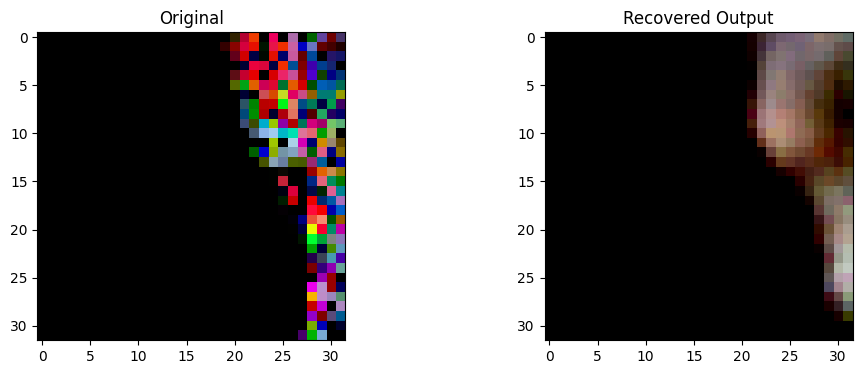

In [28]:

# 학습된 모델로 테스트 이미지 확인
auto_10.eval()
with torch.no_grad():
    data_iter = iter(train_loader_attacked)
    images, _ = next(data_iter)

    outputs = auto_10(images.cuda())
    
    # 첫 번째 배치의 이미지 1개만 보여주기
    show_images(images[0], outputs[0].cpu())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3335047..0.8016833].


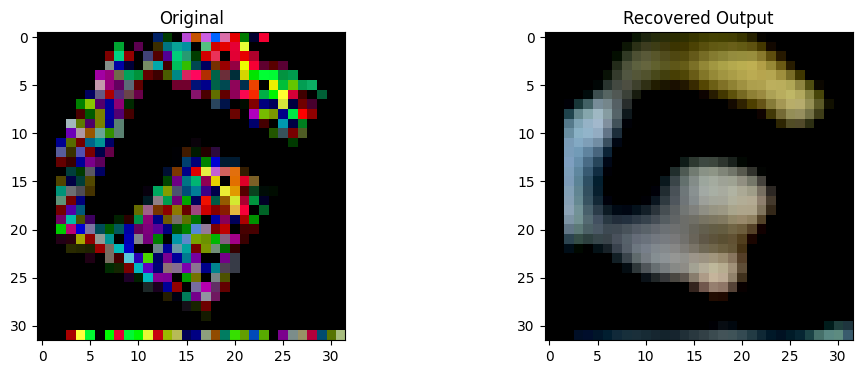

In [29]:

# 학습된 모델로 테스트 이미지 확인
auto_attacked.eval()
with torch.no_grad():
    data_iter = iter(train_loader_attacked)
    images, _ = next(data_iter)

    outputs = unet_attacked(images.cuda())
    
    # 첫 번째 배치의 이미지 1개만 보여주기
    show_images(images[0], outputs[0].cpu())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2422284..0.7689277].


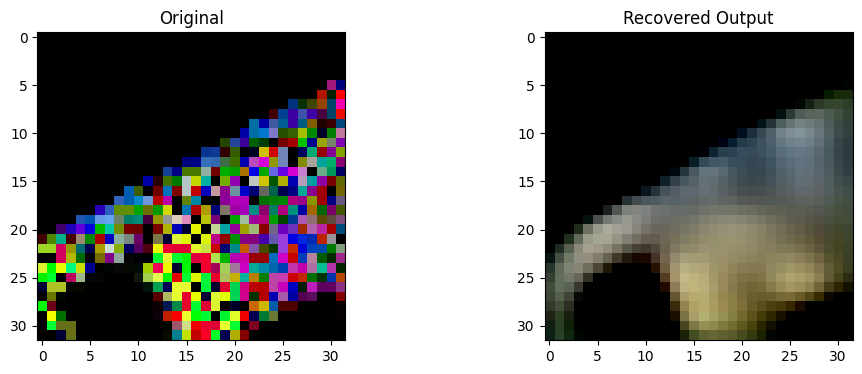

In [30]:

# 학습된 모델로 테스트 이미지 확인
unet_attacked.eval()
with torch.no_grad():
    data_iter = iter(train_loader_attacked)
    images, _ = next(data_iter)

    outputs = unet_attacked(images.cuda())
    
    # 첫 번째 배치의 이미지 1개만 보여주기
    show_images(images[0], outputs[0].cpu())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.82755375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


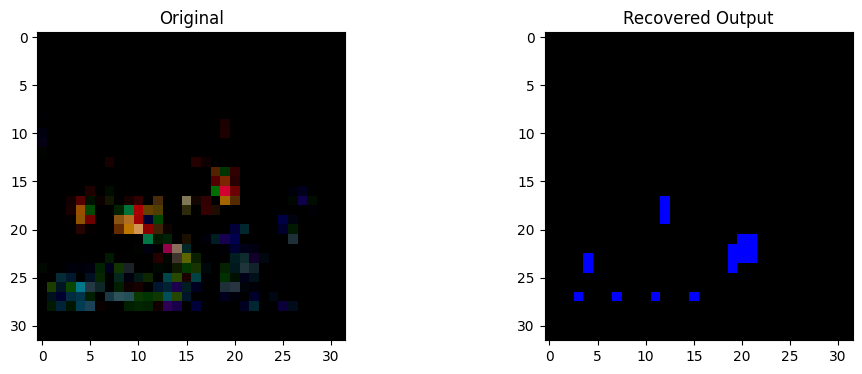

In [31]:

# 학습된 모델로 테스트 이미지 확인
auto_100.eval()
with torch.no_grad():
    data_iter = iter(train_loader_attacked)
    images, _ = next(data_iter)

    outputs = auto_100(images.cuda())
    
    # 첫 번째 배치의 이미지 1개만 보여주기
    show_images(images[0], outputs[0].cpu())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.185963..0.6604592].


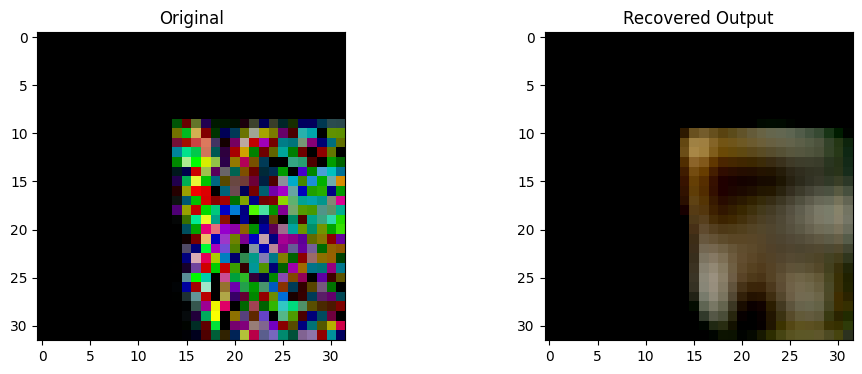

In [32]:

# 학습된 모델로 테스트 이미지 확인
unet_100.eval()
with torch.no_grad():
    data_iter = iter(train_loader_attacked)
    images, _ = next(data_iter)

    outputs = unet_100(images.cuda())
    
    # 첫 번째 배치의 이미지 1개만 보여주기
    show_images(images[0], outputs[0].cpu())


#### 중독된 데이터 복구

In [33]:
class CIFAR10WithModelOutputAndLabels(Dataset):
    def __init__(self, original_data, model_outputs, labels):
        self.original_data = original_data
        self.model_outputs = model_outputs
        self.labels = labels

    def __len__(self):
        return len(self.original_data)

    def __getitem__(self, idx):
        return self.original_data[idx], self.model_outputs[idx], self.labels[idx]

# 이미지를 모델에 통과시키고 출력 저장하는 함수
def process_and_save_cifar10(dataloader, model, output_filename="processed_cifar10_with_labels.pth"):
    """
    CIFAR-10 DataLoader에서 이미지를 처리하고, 모델의 출력과 라벨을 저장하는 함수.
    """
    model.eval()  # 모델을 평가 모드로 설정

    all_images = []
    all_outputs = []
    all_labels = []

    with torch.no_grad():  # 예측 시에는 그래디언트 계산을 하지 않음
        for images, labels in dataloader:
            # 이미지를 GPU로 이동 (GPU가 사용 가능하면)
            images = images.cuda() if torch.cuda.is_available() else images
            labels = labels.cuda() if torch.cuda.is_available() else labels

            # 모델을 통해 예측 결과 얻기
            outputs = model(images)

            # 결과를 리스트에 추가
            all_images.append(images.cpu())  # CPU로 이동하여 저장
            all_outputs.append(outputs.cpu())  # CPU로 이동하여 저장
            all_labels.append(labels.cpu())  # CPU로 이동하여 저장

    # CIFAR-10 이미지, 모델 출력, 라벨을 포함한 Dataset 생성
    combined_dataset = CIFAR10WithModelOutputAndLabels(
        torch.cat(all_images), torch.cat(all_outputs), torch.cat(all_labels)
    )

    # PyTorch Dataset을 저장
    torch.save(combined_dataset, output_filename)
    print(f"Processed data with labels saved to {output_filename}")


C:\Users\eaton\AppData\Local\Temp\ipykernel_25184\3093957401.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_auto_10 = torch.load("auto_10.pth")
Clipping input data t

Processed data with labels saved to auto_10.pth


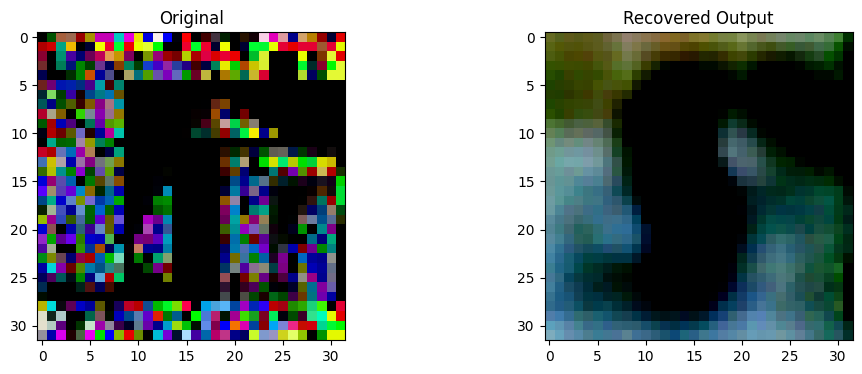

In [34]:
# auto_10
if __name__ == "__main__":
    # CIFAR-10 DataLoader 로드
    cifar10_loader = train_loader_attacked

    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    process_and_save_cifar10(train_loader_attacked, auto_10, output_filename="auto_10.pth")

# 저장된 파일 로드 예시
s_auto_10 = torch.load("auto_10.pth")

# 데이터, 출력, 라벨 가져오기
images, outputs, labels = s_auto_10.original_data, s_auto_10.model_outputs, s_auto_10.labels

# 예를 들어, 첫 번째 이미지와 출력 확인하기
show_images(images[0], outputs[0])


C:\Users\eaton\AppData\Local\Temp\ipykernel_25184\2077782837.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_unet_10 = torch.load("unet_10.pth")
Clipping input data t

Processed data with labels saved to unet_10.pth


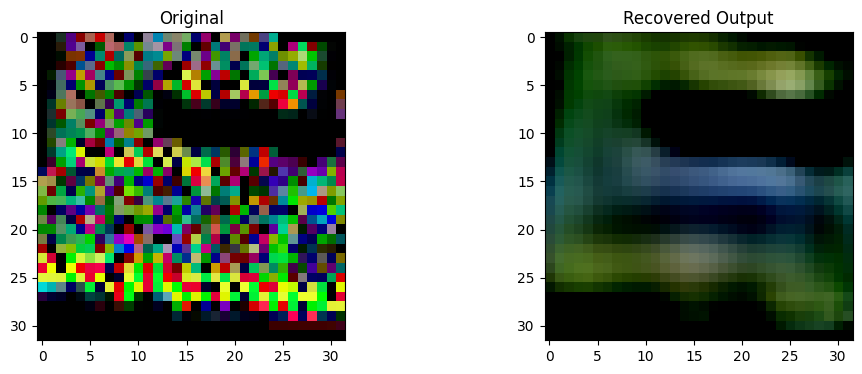

In [35]:
# unet_10
if __name__ == "__main__":
    # CIFAR-10 DataLoader 로드
    cifar10_loader = train_loader_attacked

    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    process_and_save_cifar10(train_loader_attacked, unet_10, output_filename="unet_10.pth")

# 저장된 파일 로드 예시
s_unet_10 = torch.load("unet_10.pth")

# 데이터, 출력, 라벨 가져오기
images, outputs, labels = s_unet_10.original_data, s_unet_10.model_outputs, s_unet_10.labels

# 예를 들어, 첫 번째 이미지와 출력 확인하기
show_images(images[0], outputs[0])

C:\Users\eaton\AppData\Local\Temp\ipykernel_25184\1867738809.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_auto_attacked = torch.load("auto_attacked.pth")
Clipping 

Processed data with labels saved to auto_attacked.pth


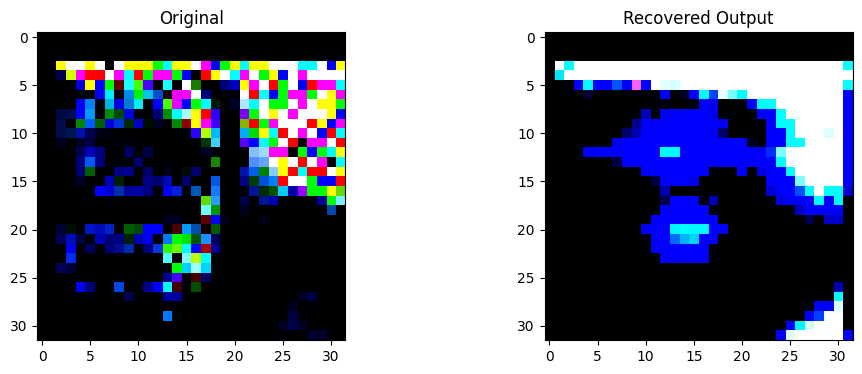

In [36]:
# auto_attack
if __name__ == "__main__":
    # CIFAR-10 DataLoader 로드
    cifar10_loader = train_loader_attacked

    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    process_and_save_cifar10(train_loader_attacked, auto_attacked, output_filename="auto_attacked.pth")

# 저장된 파일 로드 예시
s_auto_attacked = torch.load("auto_attacked.pth")

# 데이터, 출력, 라벨 가져오기
images, outputs, labels = s_auto_attacked.original_data, s_auto_attacked.model_outputs, s_auto_attacked.labels

# 예를 들어, 첫 번째 이미지와 출력 확인하기
show_images(images[0], outputs[0])


C:\Users\eaton\AppData\Local\Temp\ipykernel_25184\3956542250.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_unet_attacked = torch.load("unet_attacked.pth")
Clipping 

Processed data with labels saved to unet_attacked.pth


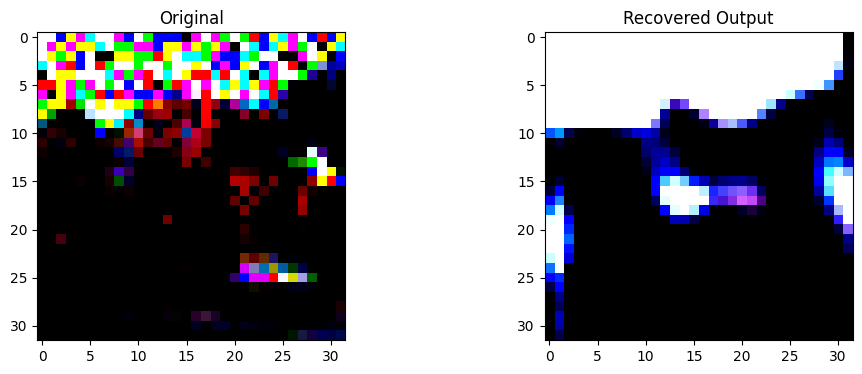

In [37]:
# unet_attack
if __name__ == "__main__":
    # CIFAR-10 DataLoader 로드
    cifar10_loader = train_loader_attacked

    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    process_and_save_cifar10(train_loader_attacked, unet_attacked, output_filename="unet_attacked.pth")

# 저장된 파일 로드 예시
s_unet_attacked = torch.load("unet_attacked.pth")

# 데이터, 출력, 라벨 가져오기
images, outputs, labels = s_unet_attacked.original_data, s_unet_attacked.model_outputs, s_unet_attacked.labels

# 예를 들어, 첫 번째 이미지와 출력 확인하기
show_images(images[0], outputs[0])

C:\Users\eaton\AppData\Local\Temp\ipykernel_25184\902041006.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_auto_100 = torch.load("auto_100.pth")
Clipping input data 

Processed data with labels saved to auto_100.pth


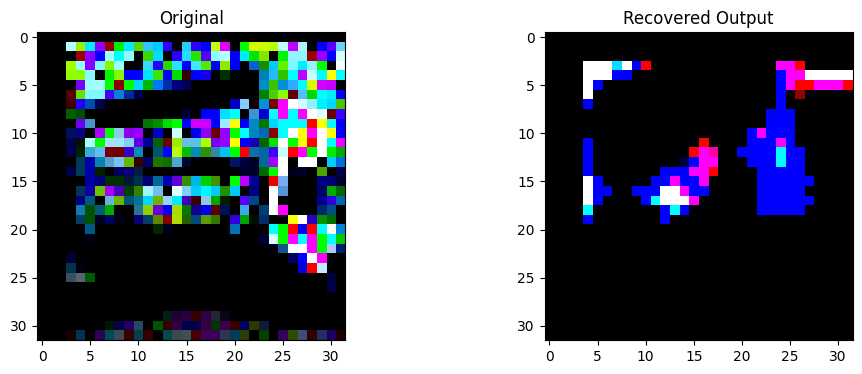

In [38]:
# auto_100
if __name__ == "__main__":
    # CIFAR-10 DataLoader 로드
    cifar10_loader = train_loader_attacked

    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    process_and_save_cifar10(train_loader_attacked, auto_100, output_filename="auto_100.pth")

# 저장된 파일 로드 예시
s_auto_100 = torch.load("auto_100.pth")

# 데이터, 출력, 라벨 가져오기
images, outputs, labels = s_auto_100.original_data, s_auto_100.model_outputs, s_auto_100.labels

# 예를 들어, 첫 번째 이미지와 출력 확인하기
show_images(images[0], outputs[0])


C:\Users\eaton\AppData\Local\Temp\ipykernel_25184\175540731.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_unet_100 = torch.load("unet_100.pth")
Clipping input data 

Processed data with labels saved to unet_100.pth


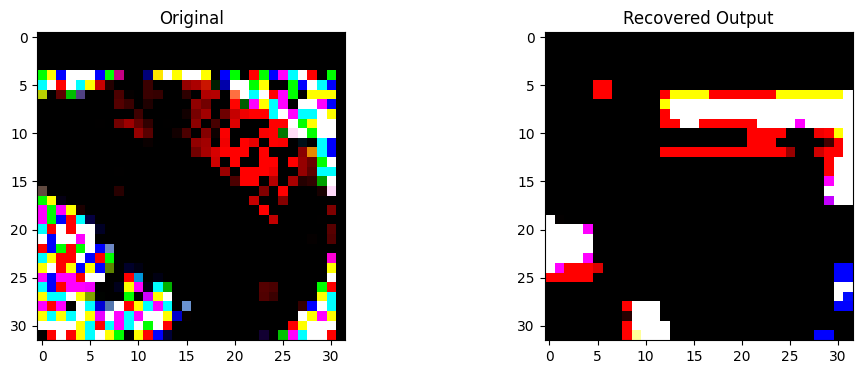

In [50]:
# unet_100
if __name__ == "__main__":
    # CIFAR-10 DataLoader 로드
    cifar10_loader = train_loader_attacked

    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    process_and_save_cifar10(train_loader_attacked, unet_100, output_filename="unet_100.pth")

# 저장된 파일 로드 예시
s_unet_100 = torch.load("unet_100.pth")

# 데이터, 출력, 라벨 가져오기
images, outputs, labels = s_unet_100.original_data, s_unet_100.model_outputs, s_unet_100.labels

# 예를 들어, 첫 번째 이미지와 출력 확인하기
show_images(images[0], outputs[0])


### 7. 복원 이미지 분류

In [40]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_auto_10 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
model_unet_10 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

model_auto_attack = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
model_unet_attack = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

model_auto_100 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
model_unet_100 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

In [41]:
train_loader_auto_10 = DataLoader(dataset=s_auto_10, batch_size=64, shuffle=True)

acc_auto_10 = train_and_evaluate_after(model_auto_10, device, train_loader_auto_10, test_loader, epochs=5)

[Epoch 1] loss: 2.049
Accuracy: 33.72%
[Epoch 2] loss: 1.908
Accuracy: 39.56%
[Epoch 3] loss: 1.798
Accuracy: 47.35%
[Epoch 4] loss: 1.730
Accuracy: 40.43%
[Epoch 5] loss: 1.676
Accuracy: 49.57%


In [42]:
train_loader_unet_10 = DataLoader(dataset=s_unet_10, batch_size=64, shuffle=True)

acc_unet_10 = train_and_evaluate_after(model_unet_10, device, train_loader_unet_10, test_loader, epochs=5)

[Epoch 1] loss: 2.051
Accuracy: 30.87%
[Epoch 2] loss: 1.903
Accuracy: 38.06%
[Epoch 3] loss: 1.784
Accuracy: 42.99%
[Epoch 4] loss: 1.707
Accuracy: 48.46%
[Epoch 5] loss: 1.643
Accuracy: 50.76%


In [43]:
train_loader_auto_attack = DataLoader(dataset=s_auto_attacked, batch_size=64, shuffle=True)

acc_auto_attack = train_and_evaluate_after(model_auto_attack, device, train_loader_auto_attack, test_loader, epochs=5)

[Epoch 1] loss: 2.076
Accuracy: 33.01%
[Epoch 2] loss: 1.934
Accuracy: 39.77%
[Epoch 3] loss: 1.804
Accuracy: 46.57%
[Epoch 4] loss: 1.732
Accuracy: 45.34%
[Epoch 5] loss: 1.665
Accuracy: 49.96%


In [44]:
train_loader_unet_attack = DataLoader(dataset=s_unet_attacked, batch_size=64, shuffle=True)

acc_unet_attack = train_and_evaluate_after(model_unet_attack, device, train_loader_unet_attack, test_loader, epochs=5)

[Epoch 1] loss: 2.046
Accuracy: 36.45%
[Epoch 2] loss: 1.888
Accuracy: 39.78%
[Epoch 3] loss: 1.780
Accuracy: 45.27%
[Epoch 4] loss: 1.703
Accuracy: 46.08%
[Epoch 5] loss: 1.634
Accuracy: 47.30%


In [45]:
train_loader_auto_100 = DataLoader(dataset=s_auto_100, batch_size=64, shuffle=True)

acc_auto_100 = train_and_evaluate_after(model_auto_100, device, train_loader_auto_100, test_loader, epochs=5)

[Epoch 1] loss: 2.063
Accuracy: 30.21%
[Epoch 2] loss: 1.909
Accuracy: 40.84%
[Epoch 3] loss: 1.807
Accuracy: 34.19%
[Epoch 4] loss: 1.732
Accuracy: 43.14%
[Epoch 5] loss: 1.679
Accuracy: 46.07%


In [46]:
train_loader_unet_100 = DataLoader(dataset=s_unet_10, batch_size=64, shuffle=True)

acc_unet_100 = train_and_evaluate_after(model_unet_100, device, train_loader_unet_100, test_loader, epochs=5)

[Epoch 1] loss: 2.064
Accuracy: 30.74%
[Epoch 2] loss: 1.916
Accuracy: 36.64%
[Epoch 3] loss: 1.811
Accuracy: 42.47%
[Epoch 4] loss: 1.742
Accuracy: 43.76%
[Epoch 5] loss: 1.681
Accuracy: 49.94%


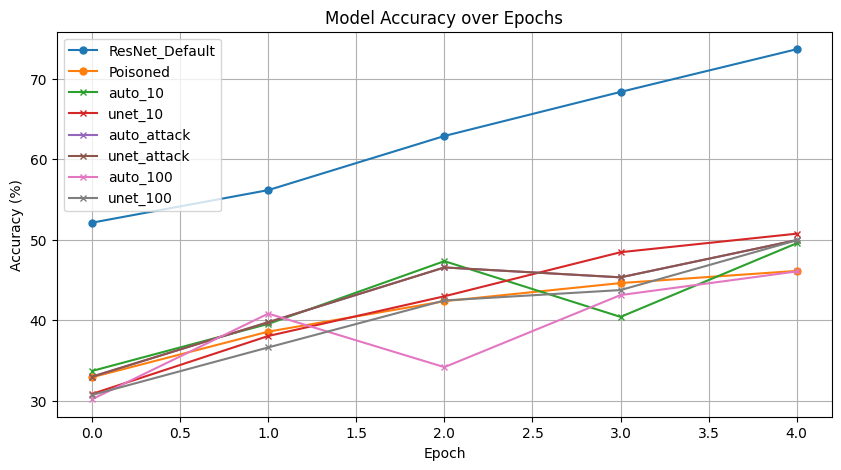

In [47]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='Poisoned')
plt.plot(acc_auto_10, marker='x', linestyle='-', markersize=5, label='auto_10')
plt.plot(acc_unet_10, marker='x', linestyle='-', markersize=5, label='unet_10')
plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='auto_attack')
plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='unet_attack')
plt.plot(acc_auto_100, marker='x', linestyle='-', markersize=5, label='auto_100')
plt.plot(acc_unet_100, marker='x', linestyle='-', markersize=5, label='unet_100')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()